# IFT870 - Examen final

Auteur : Aurélien Vauthier (19 126 456)

## Préparation des données

In [1]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import adjusted_rand_score, make_scorer, silhouette_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from scipy.spatial.distance import cdist, pdist, squareform
from itertools import combinations
from tqdm import tqdm
import numpy as np
import pandas as pd
# %matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Chargement d'un ensemble de données de faces de personnages connus
from sklearn.datasets import fetch_lfw_people

In [3]:
faces = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

In [4]:
# format des images et nombres de clusters
print("Format des images: {}".format(faces.images.shape))
print("Nombre de classes: {}".format(len(faces.target_names)))

Format des images: (3023, 87, 65)
Nombre de classes: 62


In [5]:
# nombre de données par cluster
nombres = np.bincount(faces.target)
for i, (nb, nom) in enumerate(zip(nombres, faces.target_names)):
    print("{0:25} {1:3}".format(nom, nb), end='   ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39   Alvaro Uribe               35   Amelie Mauresmo            21   
Andre Agassi               36   Angelina Jolie             20   Ariel Sharon               77   
Arnold Schwarzenegger      42   Atal Bihari Vajpayee       24   Bill Clinton               29   
Carlos Menem               21   Colin Powell              236   David Beckham              31   
Donald Rumsfeld           121   George Robertson           22   George W Bush             530   
Gerhard Schroeder         109   Gloria Macapagal Arroyo    44   Gray Davis                 26   
Guillermo Coria            30   Hamid Karzai               22   Hans Blix                  39   
Hugo Chavez                71   Igor Ivanov                20   Jack Straw                 28   
Jacques Chirac             52   Jean Chretien              55   Jennifer Aniston           21   
Jennifer Capriati          42   Jennifer Lopez             21   Jeremy Greenstock          24   
Jiang Zemin                20 

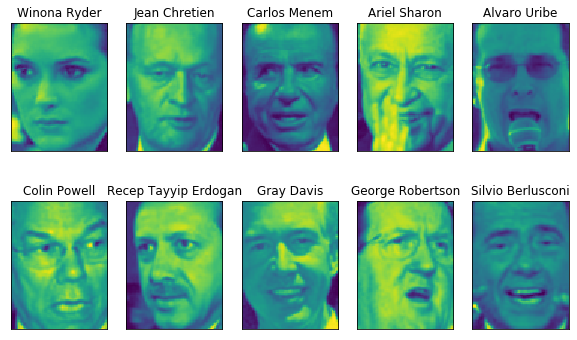

In [6]:
# Affichage des 10 premières faces
fig, axes = plt.subplots(2, 5, figsize=(10, 6),
                         subplot_kw={'xticks': (), 'yticks': ()})
for nom, image, ax in zip(faces.target, faces.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(faces.target_names[nom])

In [7]:
# Convert data array to DataFrame and append targets
data = pd.DataFrame(faces.data)
data["target"] = faces.target

# keep the first 40 data for each target
data = data.groupby("target").head(40)

# show results
data.head()

,0,1,2,3,4,5,6,7,8,9,...,5646,5647,5648,5649,5650,5651,5652,5653,5654,target
0,57.000000,60.333332,78.000000,120.666664,156.000000,178.000000,195.333328,210.666672,221.333328,222.333328,...,41.666668,17.333334,15.666667,20.000000,19.000000,18.333334,17.333334,16.666666,22.666666,61
1,66.666664,80.666664,88.666664,68.000000,63.333332,96.000000,115.333336,127.666664,139.000000,148.333328,...,25.333334,18.666666,11.666667,8.666667,8.000000,8.666667,8.666667,8.333333,9.333333,25
2,18.666666,14.333333,15.000000,13.666667,14.666667,23.333334,55.333332,92.666664,125.666664,154.666672,...,253.000000,251.333328,240.666672,172.666672,47.666668,20.666666,22.666666,22.666666,25.666666,9
3,76.666664,113.666664,172.000000,201.666672,199.333328,190.333328,177.000000,167.666672,167.666672,171.333328,...,82.000000,115.000000,131.666672,137.333328,136.666672,138.333328,140.666672,143.000000,143.333328,5
4,79.000000,70.000000,70.333336,81.666664,99.000000,126.000000,144.333328,156.666672,164.333328,168.666672,...,88.666664,91.000000,90.000000,89.666664,85.333336,83.000000,80.333336,74.000000,64.333336,1


In [8]:
# apply PCA to reduce dimensionality and increase models
pca = PCA(100, whiten=True, random_state=0)
data = pca.fit_transform(data.drop("target", axis=1))


def robustness(clusterings):
    len_P = 0
    same_cluster_counter = 0
    n_pairs = len(list(combinations(range(clusterings.shape[0]), 2)))

    for i, j in tqdm(combinations(range(clusterings.shape[0]), 2), total=n_pairs, desc="Computing robustness"):
        same_cluster_count = np.sum(clusterings[i] == clusterings[j])

        same_cluster_counter += same_cluster_count
        len_P += same_cluster_count > 0

    return same_cluster_counter / (len_P * clusterings.shape[1])


## Question 1 : Robustesse aux changement de paramètres d’un modèle KMeans ou AgglomerativeCLustering

*Écrivez une fonction prenant en paramètre une instance de la classe KMeans ou de la
classe AgglomerativeClustering, et retournant la robustesse de cette instance, calculée
comme suit :*

*Faire varier uniquement le paramètre n_clusters de l’instance en lui additionnant les valeurs 
`[-5,-4,-3,-2,-1,0,1,2,3,4,5]`. Pour chaque valeur du paramètre n_clusters, entraîner le modèle et
prédire un clustering. Calculer le score de robustesse R correspondant aux 11 clusterings obtenus.*

In [9]:
def n_clusters_robustness(model):
    n_clusters_modifications = range(-5, 6)
    predictions = np.zeros((data.shape[0], len(n_clusters_modifications)))
    desc = f"Fitting and predicting {type(model).__name__} with n_clusters={model.n_clusters}"

    for i, modification in tqdm(enumerate(n_clusters_modifications), total=len(n_clusters_modifications), desc=desc):
        model.n_clusters += modification
        prediction = model.fit_predict(data)
        predictions[:, i] = prediction

    return robustness(predictions)


*Calculer la robustesse des modèles : `KMeans(n_clusters=k, random_state=0)` et
`AgglomerativeClustering(n_clusters=k)` pour k = 40, 60 ou 80. Quel est le modèle le plus
robuste suivant le score R ?*

Computing robustness: 100%|██████████| 1834570/1834570 [00:14<00:00, 130618.08it/s]
Fitting and predicting AgglomerativeClustering with n_clusters=40: 100%|██████████| 11/11 [00:01<00:00,  6.89it/s]
Computing robustness: 100%|██████████| 1834570/1834570 [00:14<00:00, 129451.57it/s]
Fitting and predicting AgglomerativeClustering with n_clusters=60: 100%|██████████| 11/11 [00:01<00:00,  6.88it/s]
Computing robustness: 100%|██████████| 1834570/1834570 [00:13<00:00, 135207.27it/s]
Fitting and predicting AgglomerativeClustering with n_clusters=80: 100%|██████████| 11/11 [00:01<00:00,  6.80it/s]
Computing robustness: 100%|██████████| 1834570/1834570 [00:13<00:00, 134567.30it/s]


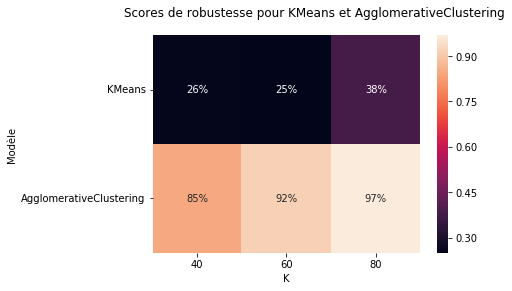

In [10]:
k_means_robustness = []
agglomerative_clustering_robustness = []

for k in range(40, 81, 20):
    kmean = KMeans(n_clusters=k, random_state=0, n_jobs=-1)
    agglo = AgglomerativeClustering(n_clusters=k)

    k_means_robustness.append(n_clusters_robustness(kmean))
    agglomerative_clustering_robustness.append(n_clusters_robustness(agglo))

sns.heatmap([k_means_robustness, agglomerative_clustering_robustness],
            xticklabels=range(40, 81, 20), yticklabels=["KMeans", "AgglomerativeClustering"], annot=True, fmt=".0%")
plt.suptitle("Scores de robustesse pour KMeans et AgglomerativeClustering")
plt.xlabel("K")
plt.ylabel("Modèle")
plt.yticks(rotation=0, va="center")
plt.show()

Les résultats ci-dessus semblent démontrer d'une faible robustesse du modèle `KMeans` et une forte
robustesse pour `AgglomerativeClustering` aux changements de l'hyperparamètre `n_clusters`. On peut aussi noter que les
modèles sont plus robustes lorsque le nombre de clusters est élevé. On remarque aussi en particulier une nette
amélioration pour KMeans avec 80 clusters par rapport à 40 et 60 clusters.

Le meilleur modèle est donc ici `AgglomerativeClustering` avec `n_clusters=80`.

## Question 2 : Robustesse aux changement de paramètres d’un modèle DBSCAN

*Écrivez une fonction prenant en paramètre une instance du modèle DBSCAN, et
retournant la robustesse de cette instance, calculée comme suit :*

*Faire varier uniquement le paramètre eps de l’instance en lui additionnant les valeurs 
`[-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4,0.5]`. Pour chaque valeur du paramètre eps, entraîner le
modèle et prédire un clustering. Calculer le score de robustesse R correspondant aux 11
clusterings obtenus.*

In [11]:
def eps_robustness(model):
    eps_modifications = np.arange(-0.5, 0.6, 0.1)
    predictions = np.zeros((data.shape[0], len(eps_modifications)))
    desc = f"Fitting and predicting {type(model).__name__} with eps={model.eps}"

    for i, modification in tqdm(enumerate(eps_modifications), total=len(eps_modifications), desc=desc):
        model.eps += modification
        prediction = model.fit_predict(data)
        predictions[:, i] = prediction

    return robustness(predictions)


*Calculer la robustesse des modèles : `DBSCAN(min_samples=3, eps=e)` pour k = 7, 8 ou 9.
Quel est le modèle le plus robuste suivant le score R ?*

Computing robustness: 100%|██████████| 1834570/1834570 [00:13<00:00, 131147.66it/s]


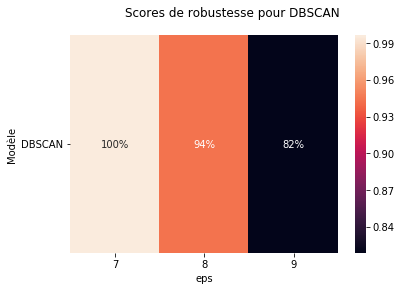

In [12]:
dbscan_robustness = []

for eps in range(7, 10):
    dbscan = DBSCAN(min_samples=3, eps=eps, n_jobs=-1)
    dbscan_robustness.append(eps_robustness(dbscan))

sns.heatmap([dbscan_robustness], xticklabels=range(7, 10), yticklabels=["DBSCAN"], annot=True, fmt=".0%")
plt.suptitle("Scores de robustesse pour DBSCAN")
plt.xlabel("eps")
plt.ylabel("Modèle")
plt.yticks(rotation=0, va="center")
plt.show()

On remarque ici une grande résistance du modèle DBSCAN aux variations d'`eps`, en particulier lorsque ce dernier est
faible. On peut ainsi noter cette tendance des modèles de clustering à être plus robuste lorsqu'on privilégie un grand
nombre de clusters.

Le meilleur modèle de DBSCAN est ainsi celui avec `eps=7`.

## Question 3 : Robustesse à l’ajout de bruit d’un modèle KMeans ou AgglomerativeCLustering

*Écrivez une fonction prenant en paramètres une instance de la classe KMeans ou de la
classe AgglomerativeClustering et un entier X de valeur comprise entre 0 et 100
représentant un pourcentage, et retournant la robustesse de cette instance, calculée comme
suit :*

*Générer aléatoirement 10 ensembles contenant chacun $X\times1960\div100$ données (bruit) de la
même forme que les données utilisées (5655 dimensions) suivant la loi normale N(μ, σ2) pour
chaque dimension telle que μ est la moyenne de la dimension et σ2 sa variance (utiliser
numpy.random.randn par exemple). Le 11e ensemble de bruit est vide. Faire varier les
données en leur ajoutant à chaque itération un des ensembles de bruit générés. Pour chaque
itération, entraîner le modèle et prédire un clustering. Calculer le score de robustesse R
correspondant aux 11 clusterings obtenus.*

In [13]:
def noise_generator(X):
    mu = data.mean(axis=0)
    sigma = data.var(axis=0)

    return np.random.normal(mu, sigma, (X*data.shape[0]//100, data.shape[1]))


def noise_robustness(model, X):
    predictions = np.zeros((data.shape[0], 11))
    n_noise_pred = predictions.shape[1] - 1  # number of prediction with noise
    desc = f"Fitting and predicting {type(model).__name__} with random noise"

    with tqdm(total=predictions.shape[1], desc=desc) as progress_bar:
        for i in range(n_noise_pred):
            noise = noise_generator(X)
            prediction = model.fit_predict(np.concatenate((data, noise)))
            predictions[:, i] = prediction[:data.shape[0]]
            progress_bar.update(1)

        predictions[:, n_noise_pred] = model.fit_predict(data)
        progress_bar.update(1)

    return robustness(predictions)


*Calculer la robustesse des modèles : KMeans(n_clusters=k, random_state=0) et
AgglomerativeClustering(n_clusters=k) pour k = 40, 60 ou 80, pour une valeur X = 5. Quel
est le modèle le plus robuste suivant le score R ?*

Computing robustness: 100%|██████████| 1834570/1834570 [00:13<00:00, 132570.25it/s]
Fitting and predicting AgglomerativeClustering with random noise: 100%|██████████| 11/11 [00:01<00:00,  6.33it/s]
Computing robustness: 100%|██████████| 1834570/1834570 [00:14<00:00, 129346.60it/s]
Fitting and predicting AgglomerativeClustering with random noise: 100%|██████████| 11/11 [00:01<00:00,  6.29it/s]
Computing robustness: 100%|██████████| 1834570/1834570 [00:14<00:00, 130605.08it/s]
Fitting and predicting AgglomerativeClustering with random noise: 100%|██████████| 11/11 [00:01<00:00,  6.29it/s]
Computing robustness: 100%|██████████| 1834570/1834570 [00:14<00:00, 130684.17it/s]


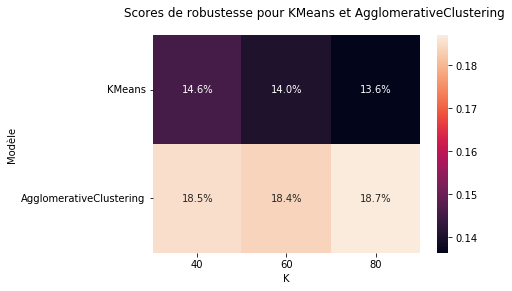

In [14]:
k_means_robustness = []
agglomerative_clustering_robustness = []
X = 5

for k in range(40, 81, 20):
    kmean = KMeans(n_clusters=k, random_state=0, n_jobs=-1)
    agglo = AgglomerativeClustering(n_clusters=k)

    k_means_robustness.append(noise_robustness(kmean, X))
    agglomerative_clustering_robustness.append(noise_robustness(agglo, X))

sns.heatmap([k_means_robustness, agglomerative_clustering_robustness],
            xticklabels=range(40, 81, 20), yticklabels=["KMeans", "AgglomerativeClustering"], annot=True, fmt=".1%")
plt.suptitle("Scores de robustesse pour KMeans et AgglomerativeClustering")
plt.xlabel("K")
plt.ylabel("Modèle")
plt.yticks(rotation=0, va="center")
plt.show()

Les résultats ci-dessus semblent démontrer d'une faible robustesse des modèles `KMeans` et `AgglomerativeClustering`
au bruit indépendamment du nombre de clusters. On peut noter qu'`AgglomerativeClustering` est un peu plus robuste.

Le meilleur modèle est donc ici `AgglomerativeClustering` avec `n_clusters=80`.

## Question 4 : Robustesse aux changement de paramètres d’un modèle DBSCAN

*Écrivez une fonction prenant en paramètre une instance du modèle DBSCAN et un
entier X de valeur comprise entre 0 et 100 représentant un pourcentage, et retournant la
robustesse de cette instance, calculée comme suit :*

*Générer aléatoirement 11 ensembles de bruit (dont 1 vide) comme indiqué à la Question 3.
Faire varier les données en leur ajoutant à chaque itération un des ensembles de bruit. Pour
chaque itération, entraîner le modèle et prédire un clustering. Calculer le score de robustesse
R correspondant aux 11 clusterings obtenus.*

La fonction `noise_robustness` peut déjà être utilisée pour le modèle `DBSCAN` sans modification, nous allons donc la 
réutiliser.

*Calculer la robustesse des modèles : DBSCAN(min_samples =3, eps=e) pour k = 7, 8 ou 9,
pour une valeur X = 5. Quel est le modèle le plus robuste suivant le score R ?*

Computing robustness: 100%|██████████| 1834570/1834570 [00:14<00:00, 129340.23it/s]


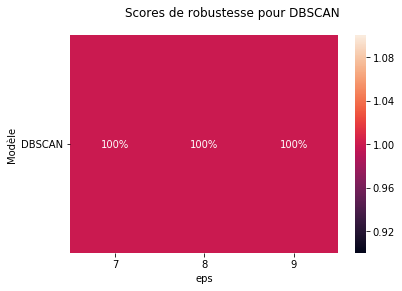

In [17]:
dbscan_robustness = []

for eps in range(7, 10):
    dbscan = DBSCAN(min_samples=3, eps=eps, n_jobs=-1)
    dbscan_robustness.append(noise_robustness(dbscan, X))
sns.heatmap([dbscan_robustness], xticklabels=range(7, 10), yticklabels=["DBSCAN"], annot=True, fmt=".0%")
plt.suptitle("Scores de robustesse pour DBSCAN")
plt.xlabel("eps")
plt.ylabel("Modèle")
plt.yticks(rotation=0, va="center")
plt.show()

Comme le prouvent les résultats ci-dessus, le modèle DBSCAN possède une excellente robustesse au bruit gaussien. Quel que
soit le paramètre `eps` ici choisi, nous obtenons un score de robustesse parfait.

## Question 5 : Modèle pour la génération du bruit

*Critiquez le modèle utilisé pour générer le bruit dans les Questions 3 et 4. Proposez un autre
modèle de bruit avec une justification du modèle.*

Le bruit généré dans les questions 3 et 4 est un bruit gaussien utilisant la distribution globale de toutes nos données
en générer de nouvelles. Bien que cette méthode de génération de bruits soit très couramment utilisée, il ne s'agit ici
que d'un type particulier de bruit. Afin de rester dans une génération de bruits blancs, nous pouvons aussi imaginer
utiliser les cibles de nos données (contenu dans `faces.target`) pour créer différentes matrices $\mu$ et $\sigma^2$
pour chaque réel cluster. Nous pourrions alors créer une loi Normale pour chaque cible et ainsi générer un bruit
différent pour chacun de ces groupes.

Par ailleurs, il serait aussi envisageable de tenter de générer d'autres types de bruits spécifiques aux photographies
comme le [bruit poivre et sel](https://fr.wikipedia.org/wiki/Bruit_poivre_et_sel), le
[bruit de grenaille](https://fr.wikipedia.org/wiki/Bruit_de_grenaille) ou encore le
[grain](https://en.wikipedia.org/wiki/Film_grain).

Puisque nous utilisons ici des données issues de photos, il pourrait aussi être intéressant d'utiliser les différentes 
techniques d'augmentations des données utilisées lors de l'entrainement des réseaux de vision par ordinateur (*computer
vision*). En particulier, nous pourrions utiliser des symétries horizontales, des modifications aléatoires
au contraste, à la luminosité et à la saturation des images, des rotations aléatoires...